<a href="https://colab.research.google.com/github/RevtiShingole/Amazon-Review_NLP-Project/blob/main/Google_Flights_Airfare_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Flights Airfare Forecast

Updated on: 2024-11-03 <br>
Author: Daniel Lee ([LinkedIn](https://www.linkedin.com/in/danleedata/))

Here’s a data science project inspired by a real-world problem. Use this opportunity to sharpen your skills and build a portfolio piece that will enhance your resume.

👉 To upskill in data science: [datascienceschool.com](https://datascienceschool.com) <br>
👉 To ace interviews in data/ML: [datainterview.com](https://datainterview.com)

------

Usage Terms:
This project is intended for personal and educational purposes only. For any other use, including commercial purposes or redistribution, please contact the author for written consent.

In [1]:
#@title Setup
from datetime import datetime, timedelta
from warnings import filterwarnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_absolute_percentage_error

# Ignore warnings
filterwarnings('ignore')

# Set seed
SEED = 123
np.random.seed(SEED)

# 🎯 Step 1 - Problem Definition

Build a data science solution that addresses the following:

1. Predict Airline Price: Build a model that forecasts the price of a flight based on its booking date. You will be provided a historical booking data that includes departure date, booking date, airline, destination and such.

2. Scenario Planning for Savings: Once your model can predict the price, we want to create a “what-if” feature. This feature will help users see how much they might save or spend by booking on different dates. For example, if a user books a flight from San Francisco to New York on December 15, they could explore alternative booking dates to see if booking on a different date would yield a better price.

In [21]:
# Load data
df_booking = pd.read_csv("google_flights_airfare_data.csv")
df_booking

,transaction_id,flight_id,airline,origin,destination,booking_dt,departure_dt,price,fare_class
0,898b2db0d,ced9a2,American Airlines,ORD,BOS,2024-04-02 14:00:10,2024-07-09 07:47:00,327.15,Economy
1,5b8144206,ced9a2,American Airlines,ORD,BOS,2024-05-19 08:44:17,2024-07-09 07:47:00,191.25,Economy
2,2e458f769,ced9a2,American Airlines,ORD,BOS,2024-02-23 22:11:51,2024-07-09 07:47:00,579.79,Economy
3,2c9e3e129,ced9a2,American Airlines,ORD,BOS,2024-04-22 23:43:37,2024-07-09 07:47:00,579.06,Economy
4,9de7ad563,ced9a2,American Airlines,ORD,BOS,2024-04-28 17:55:53,2024-07-09 07:47:00,207.06,Economy
...,...,...,...,...,...,...,...,...,...
225204,b7094a438,8e57e4,United Airlines,ATL,BOS,2022-03-22 15:15:59,2022-09-04 08:23:00,194.24,First
225205,5e2ab838b,8e57e4,United Airlines,ATL,BOS,2022-05-24 20:08:51,2022-09-04 08:23:00,160.36,First
225206,1db4ff22d,8e57e4,United Airlines,ATL,BOS,2022-07-17 16:34:38,2022-09-04 08:23:00,737.81,First
225207,fa5635ece,8e57e4,United Airlines,ATL,BOS,2022-04-05 14:44:39,2022-09-04 08:23:00,192.44,Economy


# 🗺️ Step 2 - Exploratory Data Analysis

✍️ The Exploratory Data Analysis (EDA) section delves into the provided airfare dataset to understand its characteristics, identify patterns, and uncover insights that inform model development. Here's a guideline you can consider when approaching section:

1. Generate tables and/or charts that illustrate insights.
2. Identify potential data quality issues that require addressing.
3. Discover patterns and trends that can guide feature engineering and model selection.

## Overview

In [22]:
df = df_booking.copy()

df['booking_dt'] = pd.to_datetime(df['booking_dt'])
df['departure_dt'] = pd.to_datetime(df['departure_dt'])

df['delta'] = (df['departure_dt'] - df['booking_dt']).dt.days

df.describe()

,booking_dt,departure_dt,price,delta
count,225209,225209,225209.000000,225209.000000
mean,2023-04-03 08:01:28.147392,2023-07-02 23:32:57.766874112,509.673779,90.146770
min,2021-10-12 11:58:26,2022-04-09 04:12:00,16.610000,1.000000
25%,2022-10-02 01:24:33,2023-01-03 18:56:00,245.290000,45.000000
50%,2023-04-03 14:12:02,2023-06-29 06:27:00,417.280000,90.000000
75%,2023-10-03 17:29:47,2024-01-02 13:18:00,654.300000,135.000000
max,2024-09-12 14:58:34,2024-09-15 06:11:00,6639.680000,179.000000
std,NaN,NaN,385.889088,51.656859


## Missingness

In [23]:
df_booking.isna().sum()

,0
transaction_id,0
flight_id,0
airline,0
origin,0
destination,0
booking_dt,0
departure_dt,0
price,0
fare_class,0


## Univariate Analysis

In [24]:
df['airline'].unique()

array(['American Airlines', 'Delta Air Lines', 'United Airlines'],
      dtype=object)

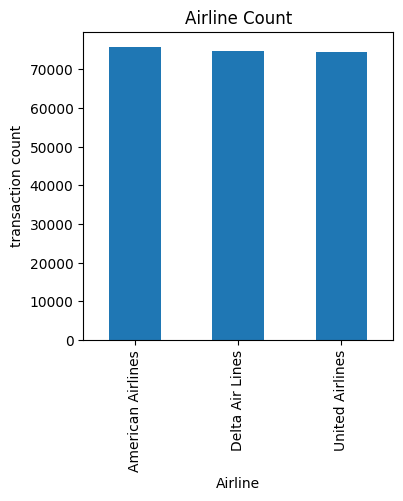

In [25]:
df.groupby('airline')['transaction_id'].count().plot(kind='bar',figsize=(4,4))
plt.title('Airline Count')
plt.xlabel('Airline')
plt.ylabel('transaction count')
plt.show()

In [26]:
print(f'fare_class:{df["fare_class"].unique()}')
print(f'origin:{df["origin"].unique()}')
print(f'destination:{df["destination"].unique()}')

fare_class:['Economy' 'Business' 'First']
origin:['ORD' 'SFO' 'ATL' 'JFK' 'LAX']
destination:['BOS' 'DFW' 'MIA' 'SEA' 'DEN']


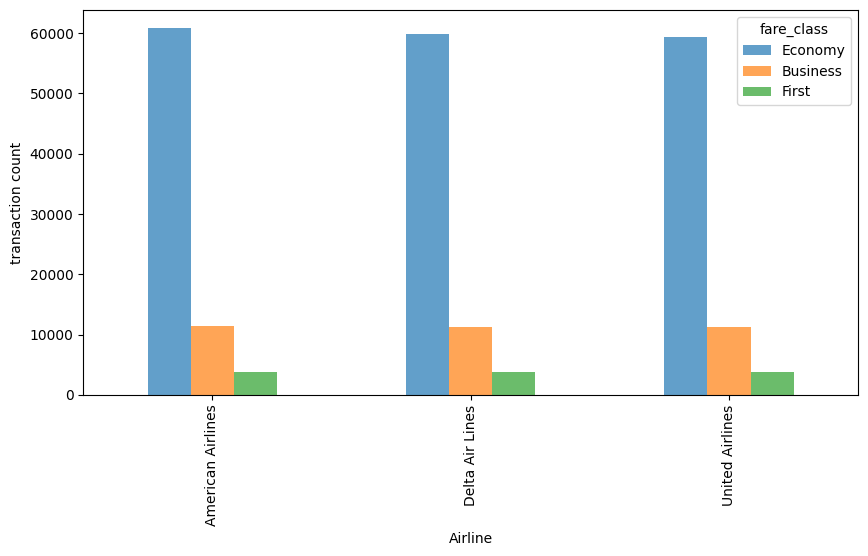

In [27]:
fare_class_order = ['Economy', 'Business', 'First']
plot_data = df.groupby(['airline','fare_class'])['transaction_id'].count().unstack()
plot_data =plot_data[fare_class_order]
ax = plot_data.plot(kind='bar',alpha=0.7,figsize=(10,5))
ax.set_xlabel('Airline')
ax.set_ylabel('transaction count')
plt.show()

## Target Analysis

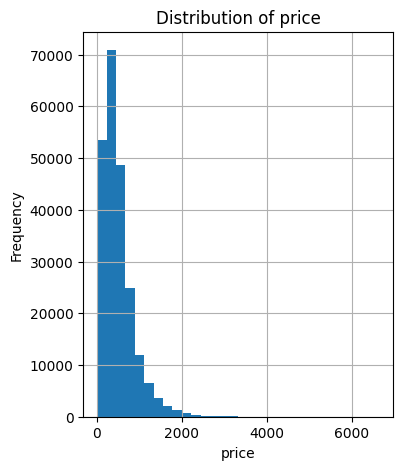

In [28]:
df['price'].hist(bins=30,figsize=(4,5))
plt.xlabel('price')
plt.ylabel('Frequency')
plt.title('Distribution of price')
plt.show()

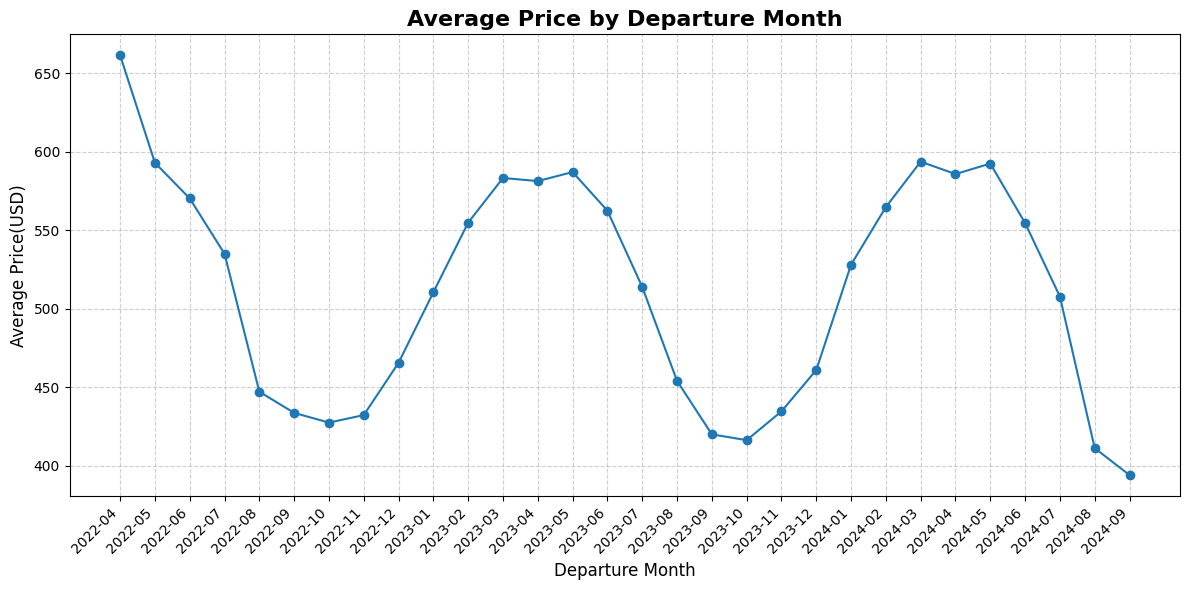

In [29]:
df['departure_year_month'] = df['departure_dt'].dt.to_period('M')
avg_price_by_month = df.groupby('departure_year_month')['price'].mean()
avg_price_by_month.index = avg_price_by_month.index.astype(str)
plt.figure(figsize=(12, 6))
plt.plot(avg_price_by_month.index, avg_price_by_month.values, linestyle='-',marker='o')
plt.xlabel('Departure Month', fontsize=12)
plt.ylabel('Average Price(USD)',fontsize = 12)
plt.title('Average Price by Departure Month',fontsize=16,weight='bold')
plt.xticks(rotation = 45, ha = 'right')
plt.grid(visible =True,linestyle = '--',alpha = 0.6)
plt.tight_layout()

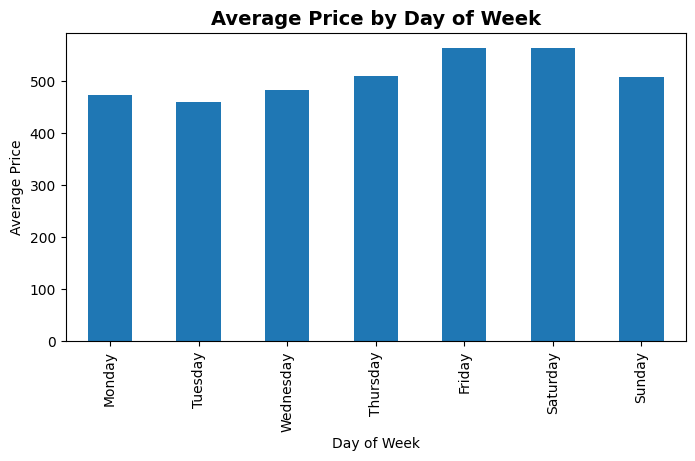

In [30]:
df['day_of_week'] = df['booking_dt'].dt.dayofweek
plot_data = df.groupby('day_of_week')['price'].agg('mean')
plot_data.index = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plot_data.plot(kind='bar',figsize=(8,4))
plt.xlabel('Day of Week')
plt.ylabel('Average Price')
plt.title('Average Price by Day of Week',fontsize=14,weight='bold')
plt.show()


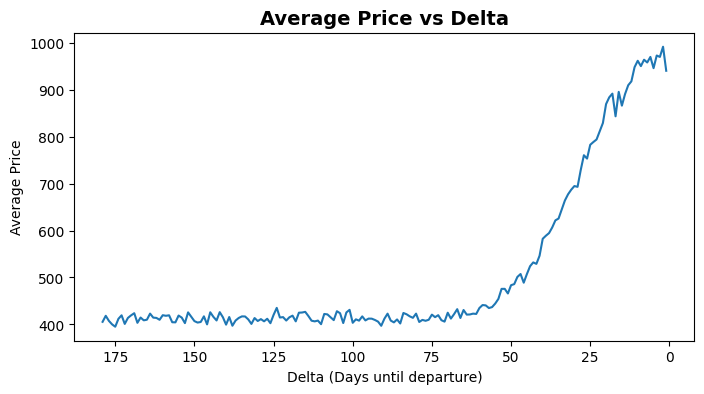

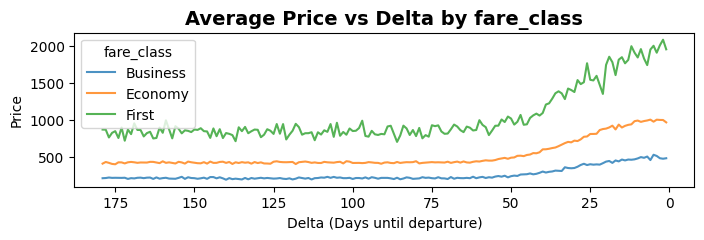

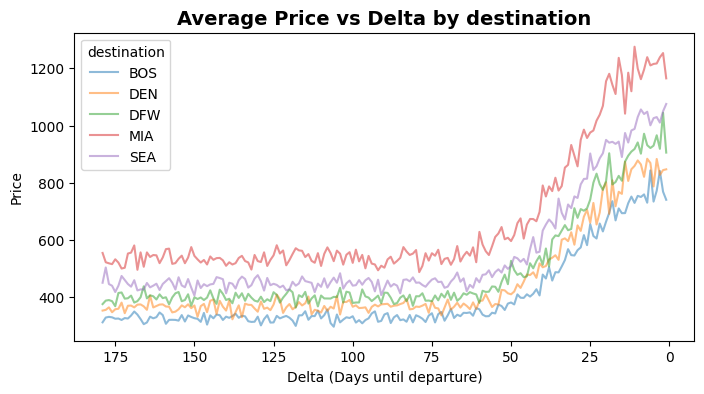

In [31]:
df.groupby('delta')['price'].mean().plot(figsize=(8,4))
plt.gca().invert_xaxis()
plt.xlabel('Delta (Days until departure)')
plt.ylabel('Average Price')
plt.title('Average Price vs Delta',fontsize=14,weight='bold')
plt.show()

df.groupby(['delta','fare_class'])['price'].mean().unstack().plot(alpha = 0.8,figsize=(8,2))
plt.gca().invert_xaxis()
plt.xlabel('Delta (Days until departure)')
plt.ylabel('Price')
plt.title('Average Price vs Delta by fare_class',fontsize=14,weight='bold')
plt.show()

df.groupby(['delta','destination'])['price'].mean().unstack().plot(alpha = 0.5, figsize=(8,4))
plt.gca().invert_xaxis()
plt.xlabel('Delta (Days until departure)')
plt.ylabel('Price')
plt.title('Average Price vs Delta by destination',fontsize=14,weight='bold')
plt.show()

# 🛢️ Step 3 - Data Preparation

✍️ Data preparation transforms raw data into a suitable format for machine learning models, enhancing their accuracy and efficiency. Your task is to clean, transform, and organize the airfare data. Here are suggestions:

*   Format Fields: Ensure data types are appropriate for analysis (e.g., datetime, categorical).
*   Split Data: Divide the dataset into training, validation, and testing sets to evaluate model performance robustly. Consider chronological order for time-series data.

💡 You are not restricted to these steps. If you identify additional steps to enhance the data, feel free to include them!

## Format Fields

In [35]:
#convert into datetime data type
df['booking_dt'] = pd.to_datetime(df['booking_dt'])
df['departure_dt'] = pd.to_datetime(df['departure_dt'])
#convert select fields into categorical data type
for col in['airline', 'origin', 'destination', 'fare_class']:
    df[col] = df[col].astype('category')

## Split Data

In [38]:
#split data
def split_data(data:pd.DataFrame,time_column:str,train_ratio=0.7,valid_ratio=0.2,test_ratio=0.1):
  """
  Splits time series data into train, validation, and test sets.

  """
  #sort data
  data = data.sort_values(time_column).reset_index(drop=True)

  #computing split indices
  n = len(data)
  train_end = int(train_ratio * n)
  valid_end = train_end + int(valid_ratio * n)

  #split dataset
  train = data.iloc[:train_end]
  valid = data.iloc[train_end:valid_end]
  test = data.iloc[valid_end:]

  #reset index
  train = train.reset_index(drop=True)
  valid = valid.reset_index(drop=True)
  test = test.reset_index(drop=True)

  # Convert 'booking_dt' and 'departure_dt' to datetime objects
  for _df in [train, valid, test]:
    _df['booking_dt'] = pd.to_datetime(_df['booking_dt'])
    _df['departure_dt'] = pd.to_datetime(_df['departure_dt'])


  return train, valid, test

df_train,df_valid,df_test = split_data(df_booking,time_column='departure_dt')

for _df in[df_train,df_valid,df_test]:
  print(f'shape: {_df.shape} |Departure Range: {_df["departure_dt"].min()} - {_df["departure_dt"].max()}')


shape: (157646, 9) |Departure Range: 2022-04-09 04:12:00 - 2023-11-27 10:49:00
shape: (45041, 9) |Departure Range: 2023-11-27 10:49:00 - 2024-04-19 12:30:00
shape: (22522, 9) |Departure Range: 2024-04-19 12:30:00 - 2024-09-15 06:11:00


# 🚀 Step 4 - Feature Engineering

✍️ Feature engineering boosts model performance! It's about creating new features from existing ones to help the model better understand the data and improve predictions.

Here are suggestions to help you create new features:

1. **Compute Delta**: Calculate the time difference between booking and departure dates, as it's likely a key factor in pricing.
2. **Decompose Timestamps**: Extract valuable information from booking and departure dates, like year, month, day of the week, etc.

💡 If you think of any other features that could be insightful, go ahead and experiment. Feature engineering is all about finding what works best for your model!

## Compute Delta

In [39]:
def compute_delta(df:pd.DataFrame,booking_col:str,departure_col:str):
  """
  Compute the time difference between booking and departure dates.
  """
  df['delta'] = (df[departure_col] - df[booking_col]).dt.days
  return df

df_train = compute_delta(df_train,booking_col='booking_dt',departure_col='departure_dt')
df_valid = compute_delta(df_valid,booking_col='booking_dt',departure_col='departure_dt')
df_test = compute_delta(df_test,booking_col='booking_dt',departure_col='departure_dt')

## Decompose TS

In [40]:
def decompose_datetime(df:pd.DataFrame, date_column: list):
  for field in date_column:
    dt_series = df[field].dt
    df[f'{field}_year'] = dt_series.year
    df[f'{field}_month'] = dt_series.month
    df[f'{field}_day'] = dt_series.day
    df[f'{field}_day_of_week'] = dt_series.dayofweek
    df[f'{field}_day_of_year'] = dt_series.dayofyear
  return df

df_train = decompose_datetime(df_train,date_column=['booking_dt','departure_dt'])
df_valid = decompose_datetime(df_valid,date_column=['booking_dt','departure_dt'])
df_test = decompose_datetime(df_test,date_column=['booking_dt','departure_dt'])


# 📍 Step 5 - Feature Selection

✍️ Feature selection prevents model overfitting and improves training speed. Find the most relevant features for model prediction. You can consider a method such as the Random Forest Feature Importance.

## RF Feature Selection

In [ ]:
# YOUR CODE BELOW

## Feature Importance

In [ ]:
# YOUR CODE BELOW

## Filter Columns

In [ ]:
# YOUR CODE BELOW

# 🤖 Step 6 - Model Selection

✍️ Model selection is where we pick the champion algorithm that will power our predictions. It's about carefully evaluating different models and choosing the one that best suits our dataset and prediction task.

Your task is to experiment with different model architectures, train them, and assess their performance.

Here are suggestions on how to start this process:

1. Baseline Model: Start by establishing a baseline performance benchmark with a simple yet effective model like XGBoost. This sets a foundation to compare against when exploring more complex approaches.

2. Hyperparameter Tuning: Fine-tune the parameters of your chosen model using techniques like grid search or random search to unlock its full potential and achieve optimal performance.

💡 Consider using the XGBoost model, or any other models (e.g., linear regression, random forest).

## Baseline Model

In [ ]:
# YOUR CODE BELOW

## Hyperparameter Tuning

In [ ]:
# YOUR CODE BELOW

# 📊 Step 7 - Evaluation

✍️ Model evaluation is where we put our model to the test and determine its true performance. It's about rigorously assessing how well our chosen model generalizes to unseen data and identifying any areas for improvement. Your task is to evaluate your model using a variety of metrics and techniques, focusing on:

Consider evaluating your model with the following points:

1. **Benchmark Comparison:** Compare your model's performance against a simple business method. This helps provide context and demonstrate the model's advantages over a simpler approach.

2. **Simpson's Paradox:** Note that model performance may vary when you assess the subgroups. Do you see that the ML approach is consistently better across subgroups such as airfare_class?

💡 Remember, model evaluation is more than just looking at a single metric. Consider using multiple metrics (e.g., MAPE, RMSE, R-squared) to get a comprehensive view of your model's performance.

## Evaluation Dataset

In [ ]:
# YOUR CODE BELOW

## Business Method


In [ ]:
# YOUR CODE BELOW

# ✈️ Step 8 - Airfare Scenario Planning

✍️ This is the main aim for the ML approach. We want to build a tool that uses ML to help useres make informed booking decisions.

Given the following inputs:

1. Current Date
2. Departure Date
3. Airline
4. Origin
5. Destination
6. Fare Class

Predict the future airfare prices across a range of potential booking dates. Present these predictions in a clear and understandable format. Consider using a chart.

💡 Consider providing an actionable insight that helps users identify the optimal booking date within a specified timeframe (e.g., next 7 days) to potentiallly maximize savings.

In [ ]:
# Choose flight

#@title Example Form
today_date = '2024-11-22' #@param {type:"string"}
departure_date = '2024-12-08' #@param {type:"string"}
airline = 'United Airlines' #@param ['American Airlines', 'Delta Air Lines', 'United Airlines']
origin = 'JFK' #@param ['JFK', 'LAX', 'ORD']
destination = 'LAX' #@param ['JFK', 'LAX', 'ORD']
fare_class = 'Business' #@param ["Economy", "Business", "First"]

# Check that the departure date is greater than the today date
if departure_date <= today_date:
    raise ValueError("Departure date must be greater than today's date.")

In [ ]:
# YOUR CODE BELOW